# Look at single animal breakdown of basic results

This is an outdated notebook.

In [1]:
%load_ext autoreload
%autoreload 2

import os, json
import numpy as np
import matplotlib.pyplot as plt
import math
import sys
from mpl_toolkits.mplot3d import axes3d, Axes3D
import scipy.io as spio
from scipy import stats
import pandas as pd
import pickle

import local_env
import scripts.ccf_analysis_utils
import scripts.functions as func

In [2]:
figfolder = '../figs/singleanimal/'
datafolder = '../data/'

os.makedirs(os.path.abspath(figfolder), exist_ok=True)

In [3]:
allen_hierarchy_name = 'mousebrainontology_heirarchy_cortexMaskExclusions21_sc.xlsx'

df = pd.read_excel(datafolder + allen_hierarchy_name,engine='openpyxl', header = None, names = ['id','region','tree'])
# correct the annotations
df['region'] = df['region'].replace({'/': ', '}, regex=True)
df['region'] = df['region'].replace({'2, 3': '2/3'}, regex=True)


r2_new = pickle.load(open(datafolder + 'r2_data_dict_smallwindows_v3.pkl', 'rb'))
#r2_new = pickle.load(open(datafolder + 'r2_data_dict_expanded_smallwindow_subtract_pertimeavg.pkl', 'rb'))


ccf_labels = r2_new['5_0']['ccf_labels'].copy()
ccf_coords = r2_new['5_0']['ccf_coords'].copy()
is_alm = r2_new['5_0']['is_alm'].copy()

alm_inds = np.where(is_alm)[0]
areas = ['Medulla','Midbrain', 'ALM', 'Striatum', 'Thalamus']

epochs = ['sample','delay','response']
r2_methods = ['old', 'old_clipped', 'new']

method_to_string = {'old': '_old', 'old_clipped': '_old', 'new': ''}

In [4]:
def get_single_area_inds(area, df, ccf_labels):
    subregion_labels = func.get_all_subregion_annotations_from_name(df, area)['region'].values
    inds = func.get_neuron_inds_for_subregions(ccf_labels, {area: subregion_labels})
    return inds[area]

In [34]:

epoch = "response"
r2_method = 'new'

r2 = r2_new['5_0']['%s_r2%s'%(epoch, method_to_string[r2_method])].copy()
if r2_method == 'old_clipped':
    r2[r2<0] = 0

fr = r2_new['5_0']['%s_fr'%epoch].copy()

fr_threshold = 2.
r2_threshold = 0.0
threshold_inds = np.where((fr>fr_threshold) & (r2>r2_threshold))[0]

ccf_labels = r2_new['5_0']['ccf_labels']

session_labels = r2_new['5_0']['session_name']
animals = list(set([sess[:5] for sess in session_labels]))
inds_for_animals = {}
for animal in np.sort(animals):
    inds_for_animals[animal] = np.intersect1d(threshold_inds,np.where([sess[:5] == animal for sess in session_labels])[0])



#### Scatter plots for areas


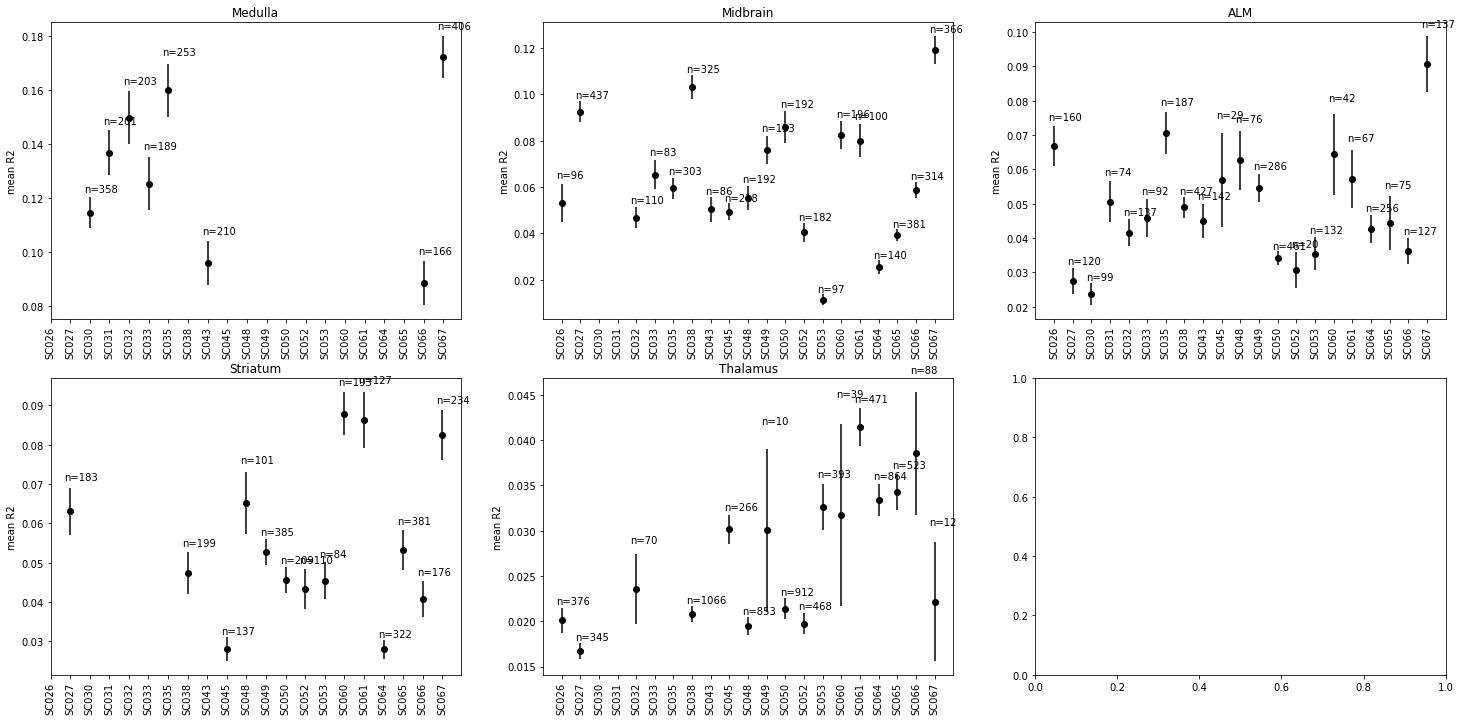

In [35]:
plt.subplots(2,3,figsize=(25,12))

for i, area in enumerate(areas):
    if area == 'ALM':
        inds = alm_inds
    else:
        inds = get_single_area_inds(area, df, ccf_labels)
    plt.subplot(2,3,i+1)

    j= 0

    for k in inds_for_animals.keys():
        v = inds_for_animals[k]
        this_animal_inds = np.intersect1d(v,inds)
        if len(this_animal_inds) == 0:
            j+=1
            continue
        mean = r2[this_animal_inds].mean()
        std = r2[this_animal_inds].std()
        sem = std/np.sqrt(this_animal_inds.shape[0])
        plt.errorbar([j],mean,yerr=sem,color = 'k', fmt = 'o')
        plt.text(j-0.3,mean + sem + 0.3 * sem, 'n=%d'%this_animal_inds.shape[0], fontsize=10, color='black')
        j+=1

    plt.title(area)
    plt.ylabel('mean R2')
    plt.xticks(np.arange(0,len(animals)), list(inds_for_animals.keys()), rotation = 90);

plt.savefig(figfolder + 'single_animal_r2_by_area.png', dpi = 300)
    

#### Single animal plots for all regions

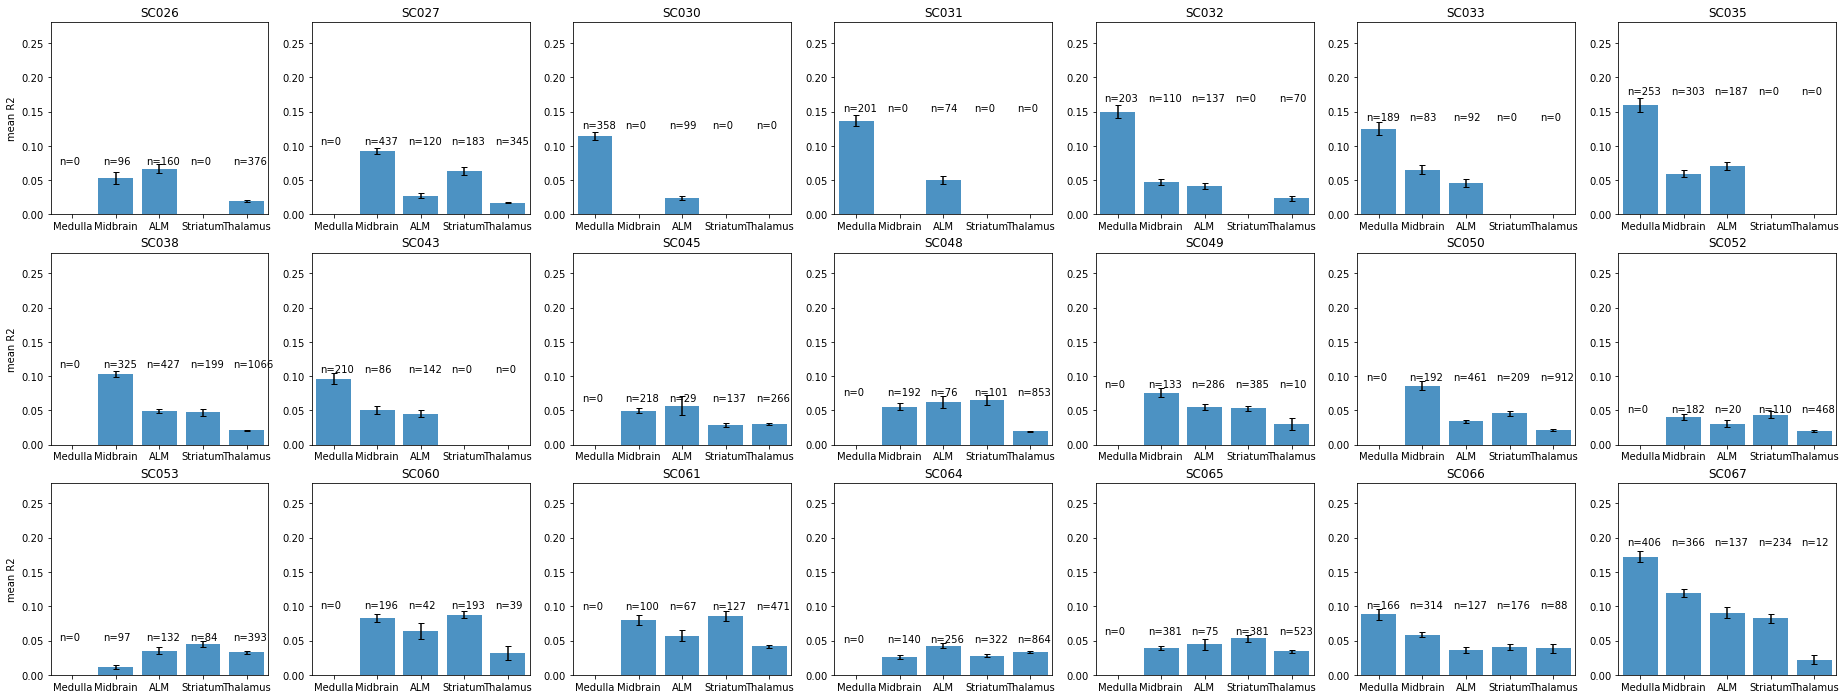

In [36]:
plt.subplots(3,7, figsize = (32,12))

for i, animal in enumerate(inds_for_animals.keys()):
    plt.subplot(3,7,i+1)
    plt.title(animal)

    area_values = []
    area_sems = []
    n_neurons = []
    for j, area in enumerate(areas):
        if area == 'ALM':
            inds = alm_inds
        else:
            inds = get_single_area_inds(area, df, ccf_labels)
        this_animal_inds = np.intersect1d(inds_for_animals[animal],inds)
        n_neurons.append(len(this_animal_inds))
        if len(this_animal_inds) == 0:
            area_values.append(np.nan)
            area_sems.append(np.nan)
            continue
        mean = r2[this_animal_inds].mean()
        std = r2[this_animal_inds].std()
        sem = std/np.sqrt(this_animal_inds.shape[0])
        area_values.append(mean)
        area_sems.append(sem)

    plt.bar(np.arange(0,len(areas)), area_values, yerr = area_sems, alpha = 0.8, capsize = 3)
    plt.xticks(np.arange(0,len(areas)), areas, rotation = 0);
    if i%7 == 0: plt.ylabel('mean R2')
    for j in range(len(areas)):
        plt.text(j-0.3,1.1*np.nanmax(area_values), 'n=%d'%n_neurons[j], fontsize=10, color='black')

    plt.xlim(-0.5,4.5)
    plt.ylim(0,0.28)

plt.savefig(figfolder + 'mean_r2_by_area_singleanimal.png')

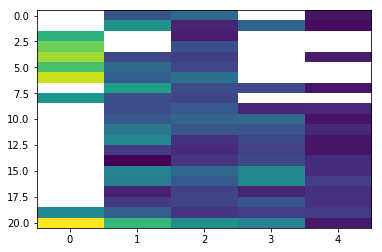

In [37]:
all_animal_means = []

for i, animal in enumerate(inds_for_animals.keys()):

    area_values = []
    area_sems = []
    n_neurons = []
    for j, area in enumerate(areas):
        if area == 'ALM':
            inds = alm_inds
        else:
            inds = get_single_area_inds(area, df, ccf_labels)
        this_animal_inds = np.intersect1d(inds_for_animals[animal],inds)
        n_neurons.append(len(this_animal_inds))
        if len(this_animal_inds) == 0:
            area_values.append(np.nan)
            area_sems.append(np.nan)
            continue
        mean = r2[this_animal_inds].mean()
        std = r2[this_animal_inds].std()
        sem = std/np.sqrt(this_animal_inds.shape[0])
        area_values.append(mean)
        area_sems.append(sem)
    all_animal_means.append(area_values)
    
plt.imshow(np.array(all_animal_means), cmap = 'viridis', aspect = 'auto')

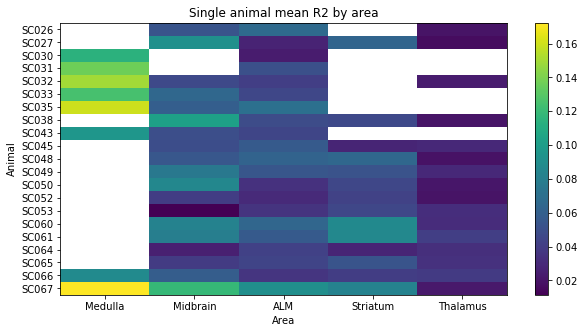

In [41]:
plt.figure(figsize = (10,5))
plt.title('Single animal mean R2 by area')
plt.xlabel('Area')
plt.ylabel('Animal')
plt.imshow(np.array(all_animal_means), cmap = 'viridis', aspect = 'auto')
plt.yticks(np.arange(0,len(animals)), list(inds_for_animals.keys()), rotation = 0);
plt.xticks(np.arange(0,len(areas)), areas, rotation = 0);
plt.colorbar()
plt.savefig(figfolder + 'mean_r2_by_area_singleanimal_heatmap.png')

Check overall area averages.

#### Leave one out plots for all regions

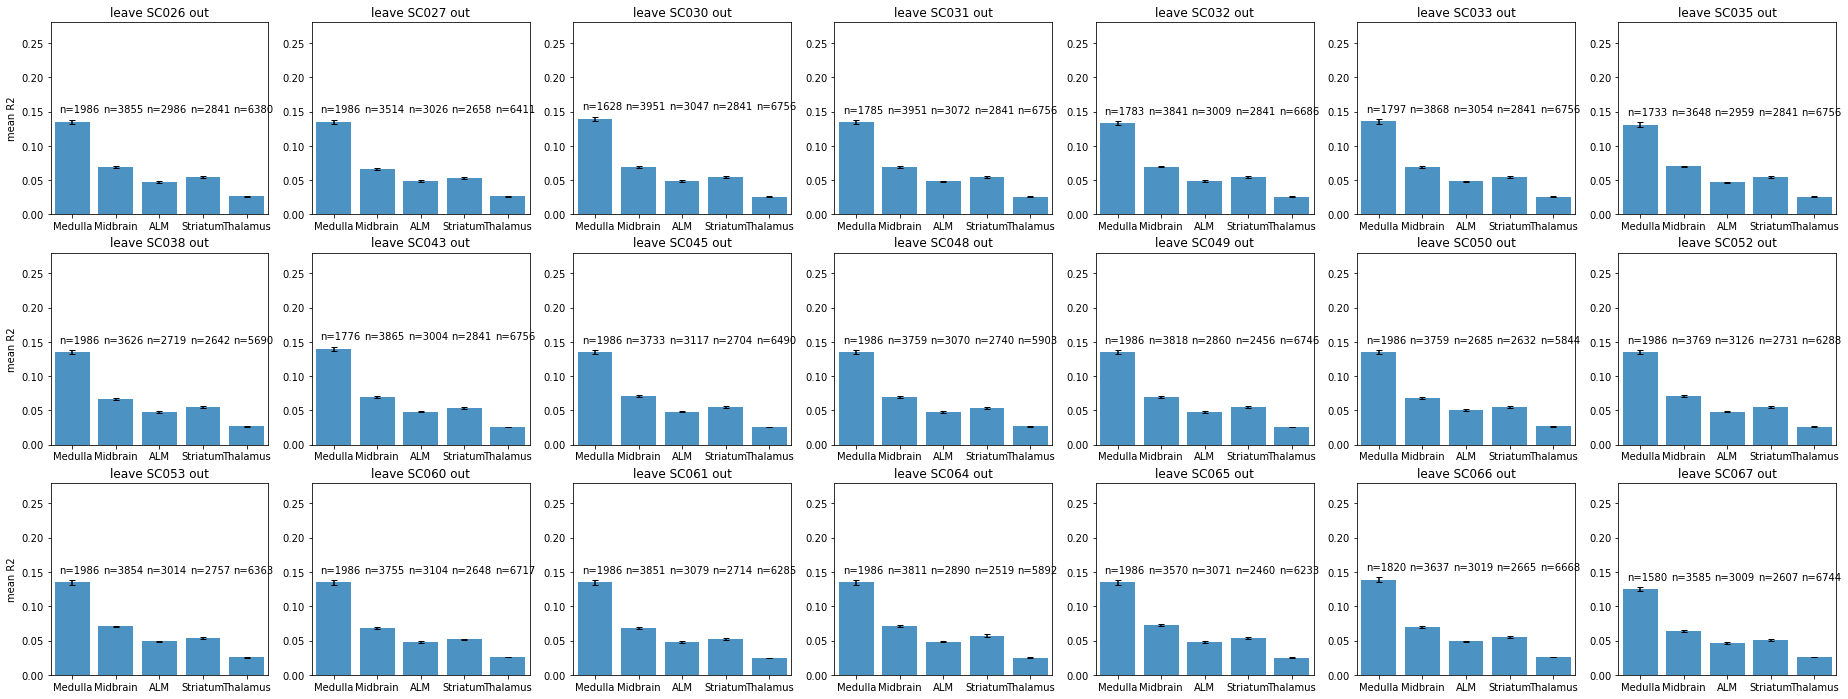

In [39]:
plt.subplots(3,7, figsize = (32,12))

area_avgs = []
area_errs = []
area_ns = []

for i, animal in enumerate(inds_for_animals.keys()):
    plt.subplot(3,7,i+1)
    plt.title('leave %s out'%animal)

    area_values = []
    area_sems = []
    n_neurons = []
    for j, area in enumerate(areas):
        if area == 'ALM':
            inds = alm_inds
        else:
            inds = get_single_area_inds(area, df, ccf_labels)
        not_this_animal_inds = np.intersect1d(threshold_inds,np.setdiff1d(inds,inds_for_animals[animal]))
        n_neurons.append(len(not_this_animal_inds))
        if len(not_this_animal_inds) == 0:
            area_values.append(np.nan)
            area_sems.append(np.nan)
            continue
        mean = r2[not_this_animal_inds].mean()
        std = r2[not_this_animal_inds].std()
        sem = std/np.sqrt(not_this_animal_inds.shape[0])
        area_values.append(mean)
        area_sems.append(sem)

    area_avgs.append(np.array(area_values))
    area_errs.append(np.array(area_sems))
    area_ns.append(np.array(n_neurons))
    plt.bar(np.arange(0,len(areas)), area_values, yerr = area_sems, alpha = 0.8, capsize = 3)
    plt.xticks(np.arange(0,len(areas)), areas, rotation = 0);
    if i%7 == 0: plt.ylabel('mean R2')
    for j in range(len(areas)):
        plt.text(j-0.3,1.1*np.nanmax(area_values), 'n=%d'%n_neurons[j], fontsize=10, color='black')

    plt.xlim(-0.5,4.5)
    plt.ylim(0,0.28)

plt.savefig(figfolder + 'mean_r2_by_area_forall_leaveoneout.png')

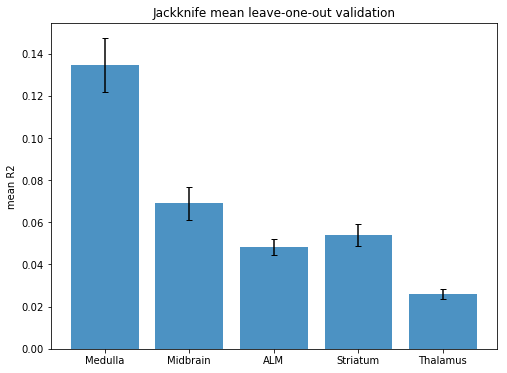

In [40]:
area_avgs = np.array(area_avgs)

jackknife_means = np.mean(area_avgs, axis = 0)
N = area_avgs.shape[0]
jackknife_vars = ((N - 1) / N) * np.sum((area_avgs - jackknife_means[np.newaxis,:])**2, axis = 0)
jackknife_se = np.sqrt(jackknife_vars)

plt.figure(figsize=(8,6))
plt.bar(np.arange(0,len(areas)), jackknife_means, yerr = jackknife_se, alpha = 0.8, capsize = 3)
plt.xticks(np.arange(0,len(areas)), areas, rotation = 0);
plt.ylabel('mean R2')
plt.title('Jackknife mean leave-one-out validation')

plt.savefig(figfolder + 'jackknife_mean_r2_by_area.png')